In [1]:
import cv2
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import os
from torchvision import transforms
from PIL import Image
from core.models import creat_mtcnn_net
from core.utils import generate_bounding_box, nms, convert_to_square

from torch.autograd.variable import Variable
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
anno_file = '/Users/shaotianyuan/DATA/WIDER/wider_face_split/wider_face_train_bbx_gt.txt'
im_dir = '/Users/shaotianyuan/DATA/WIDER/WIDER_train/images'
n = -1
lines = []
with open(anno_file) as f:
    annotations = f.readlines()
for annotation in annotations:
    annotation = annotation.strip().split(' ')
    if annotation[0][-3:] == 'jpg':
        lines.append(annotation)
        n += 1
    else:
        annotation = list(map(int, annotation))
        lines[n].extend(annotation[:4])
print(len(lines))
print(lines[:2])

12880
[['0--Parade/0_Parade_marchingband_1_849.jpg', 1, 449, 330, 122, 149], ['0--Parade/0_Parade_Parade_0_904.jpg', 1, 361, 98, 263, 339]]


[1701, 4367, 5869]


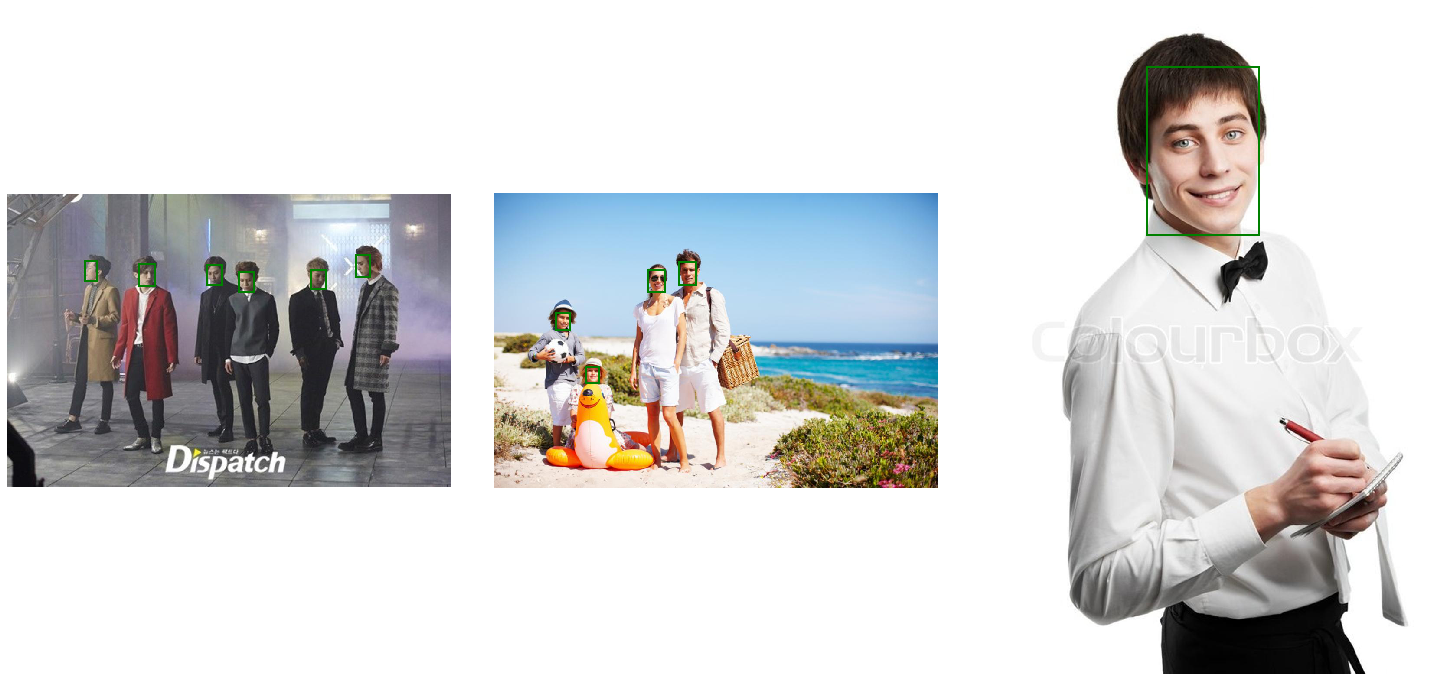

In [3]:
def my_show(lines,nums):
    lst = []
    fig, ax = plt.subplots(figsize=(20,10))
    for i in range(nums):
        n = random.randint(0,len(lines))
        lst.append(n)
        img = np.array(Image.open(os.path.join(im_dir,lines[n][0])))
        ax = plt.subplot(1, nums, i + 1)
        ax.imshow(img)
        plt.tight_layout()
        loc = np.array(lines[n][2:]).reshape(-1, 4)
        for x1, y1, x2, y2 in loc:
            rect = plt.Rectangle((x1, y1), x2, y2, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
        ax.axis('off')
            
    print(lst)
        
        
my_show(lines, 3)

In [4]:
def detect_pnet(img, pnet_path):
    
    pnet, _, _ = creat_mtcnn_net(p_model_path=pnet_path)
    all_boxes = []
    net_size = 12
    current_scale = 1
    current_height, current_width, _ = img.shape

    while min(current_height, current_width) > net_size:
        
        image = transforms.ToTensor()(img)
        image = image.unsqueeze(0)
        
        cls_map, reg = pnet(image)
        
        cls_map = cls_map[0,0,:,:]
        reg = reg[0,:,:]
        # cls_map.size = [382, 507])
        # reg.size = [4, 382, 507]
        cls_map_np = cls_map.detach().numpy()
        reg_np = np.transpose(reg.detach().numpy(), (1, 2, 0))
        
        boxes = generate_bounding_box(cls_map_np, reg_np, current_scale, 0.6)
        
        # 缩放图片
        current_scale *= 0.709
        current_height = int(0.709 * current_height)
        current_width = int(0.709 * current_width)
        
        img = cv2.resize(img, (current_width, current_height), interpolation=cv2.INTER_LINEAR)
        
        if boxes.size == 0:
            continue
        
        keep = nms(boxes[:, :5], 0.5, 'Union')
        boxes = boxes[keep]

        all_boxes.append(boxes)
        
    if len(all_boxes) == 0:
        return None, None
    
    all_boxes = np.vstack(all_boxes)
    
    keep = nms(all_boxes[:, :5], 0.7, 'Union')
    all_boxes = all_boxes[keep]
    
    
    bw = all_boxes[:, 2] - all_boxes[:, 0] + 1
    bh = all_boxes[:, 3] - all_boxes[:, 1] + 1
    
    align_topx = all_boxes[:, 0] + all_boxes[:, 5] * bw
    align_topy = all_boxes[:, 1] + all_boxes[:, 6] * bh
    align_bottomx = all_boxes[:, 2] + all_boxes[:, 7] * bw
    align_bottomy = all_boxes[:, 3] + all_boxes[:, 8] * bh
    
    boxes_align = np.array([align_topx,
                            align_topy,
                            align_bottomx,
                            align_bottomy,
                            all_boxes[:, 4]])
    
    boxes_align = boxes_align.T
    
    boxes = all_boxes[:, :5]

    
    return boxes, boxes_align

        


In [5]:
image = np.array(Image.open(os.path.join(im_dir,lines[1183][0])))
pnet_path = '/Users/shaotianyuan/PycharmProjects/face_detection/mtcnn/model_store/pnet.pkl'

P_boxes, P_boxes_align = detect_pnet(image, pnet_path)


(2748, 5)


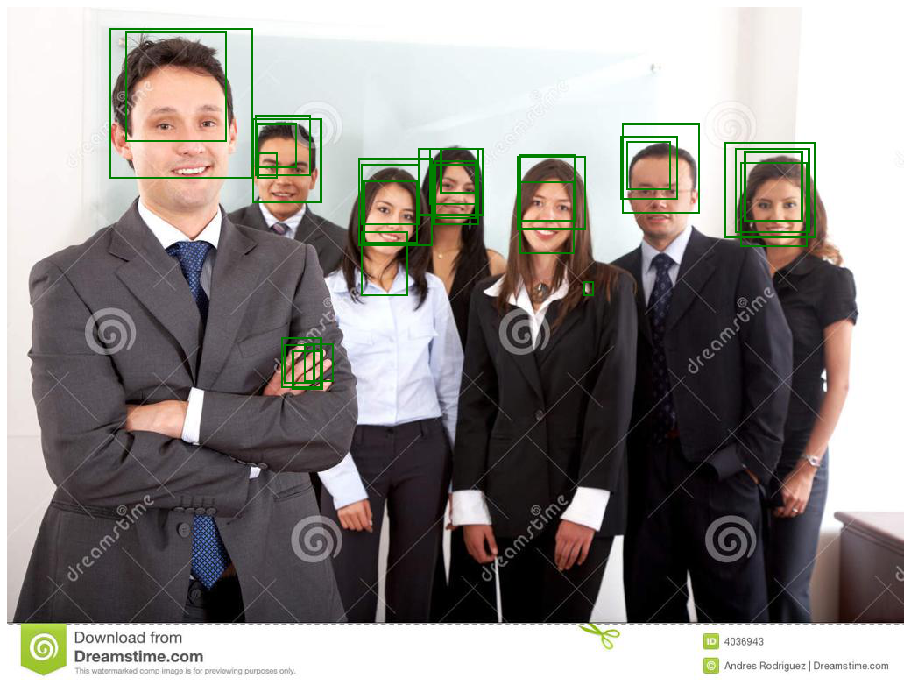

In [6]:
def my_show(img, boxes):
    fig, ax = plt.subplots(figsize=(20,10))
    ax = plt.subplot(1, 1, 1)
    ax.imshow(img)
    plt.tight_layout()
    print(boxes.shape)

    for x1, y1, x2, y2, _ in boxes[:30, :]:
        rect = plt.Rectangle((x1, y1), x2 - x1 + 1, y2 - y1 + 1, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    ax.axis('off')

my_show(image, P_boxes_align)

In [7]:
def detect_rnet(img, dets, rnet_path):
    
    h, w, c = img.shape
    _, rnet, _ = creat_mtcnn_net(r_model_path=rnet_path)
    
    if dets is None:
        return None, None
    
    dets = convert_to_square(dets)
    dets[:, 0:4] = np.round(dets[:, 0:4])
    
    num_boxes = dets.shape[0]
    cropped_ims_tensors = []
    
    for i in range(num_boxes):
        x1, y1, x2, y2, _ = [int(c) for c in dets[i]]
        
        x1 = 0 if x1 < 0 else x1
        y1 = 0 if y1 < 0 else y1
        x2 = w - 1 if x2 > w - 1 else x2
        y2 = h - 1 if y2 > h - 1 else y2
        
        tmp = img[y1: y2 + 1, x1: x2 + 1, :]

        crop_im = cv2.resize(tmp, (24, 24), interpolation=cv2.INTER_LINEAR)
        crop_im_tensor = transforms.ToTensor()(crop_im)
        
        cropped_ims_tensors.append(crop_im_tensor)

    feed_imgs = torch.stack(cropped_ims_tensors)
    cls_map_r, reg_r = rnet(feed_imgs)

    cls_map_np = cls_map_r.detach().numpy()
    reg_np = reg_r.detach().numpy()

    keep_inds = np.where(cls_map_np > 0.7)[0]

    
    if len(keep_inds) > 0:
        boxes = dets[keep_inds]
        cls = cls_map_np[keep_inds]
        reg = reg_np[keep_inds]
    else:
        return None, None
    
    keep = nms(boxes, 0.7)
    
    if len(keep) > 0:
        keep_cls = cls[keep]
        keep_boxes = boxes[keep]
        keep_reg = reg[keep]
    else:
        return None, None
    
    bw = keep_boxes[:, 2] - keep_boxes[:, 0] + 1
    bh = keep_boxes[:, 3] - keep_boxes[:, 1] + 1
    
    align_topx = keep_boxes[:,0] + keep_reg[:,0] * bw
    align_topy = keep_boxes[:,1] + keep_reg[:,1] * bh
    align_bottomx = keep_boxes[:,2] + keep_reg[:,2] * bw
    align_bottomy = keep_boxes[:,3] + keep_reg[:,3] * bh
    
    boxes_align = np.vstack([align_topx,
                             align_topy,
                             align_bottomx,
                             align_bottomy,
                             keep_cls[:, 0]])
    
    boxes_align = boxes_align.T
    
    return keep_boxes, boxes_align
    

In [8]:
image = np.array(Image.open(os.path.join(im_dir,lines[1183][0])))
rnet_path = '/Users/shaotianyuan/PycharmProjects/face_detection/mtcnn/model_store/rnet.pkl'


R_boxes, R_boxes_align = detect_rnet(image, P_boxes_align, rnet_path)



(142, 5)


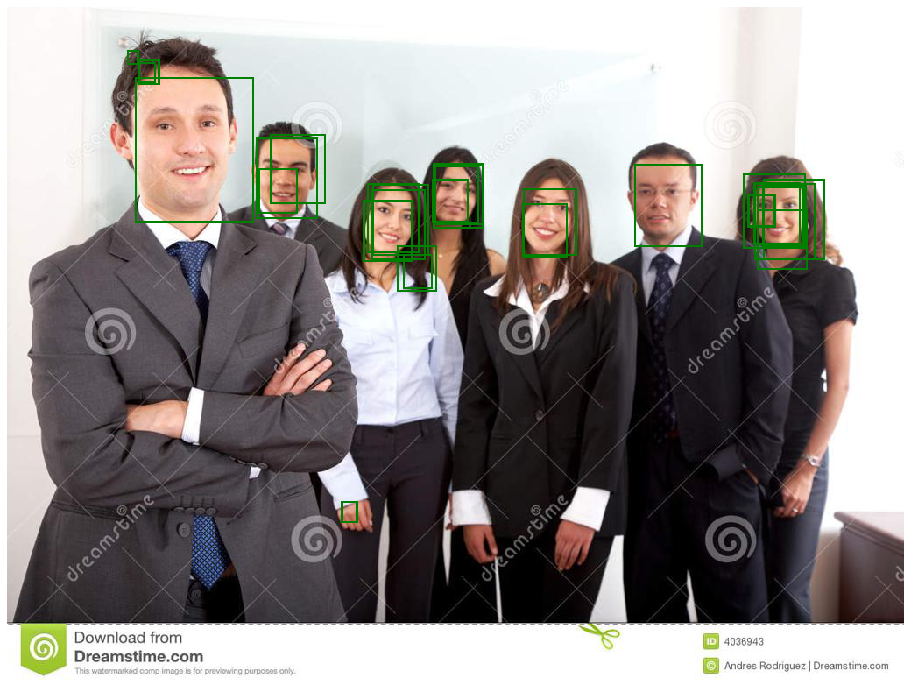

In [9]:
my_show(image, R_boxes_align)
        

In [48]:
def detect_onet(img, dets, onet_path):
    
    h, w, c = img.shape
    _, _, onet = creat_mtcnn_net(o_model_path=onet_path)
    
    if dets is None:
        return None, None
    
    dets = convert_to_square(dets)
    dets[:, 0:4] = np.round(dets[:, 0:4])
    
    num_boxes = dets.shape[0]
    cropped_ims_tensors = []
    
    for i in range(num_boxes):
        x1, y1, x2, y2, _ = [int(c) for c in dets[i]]
        
        x1 = 0 if x1 < 0 else x1
        y1 = 0 if y1 < 0 else y1
        x2 = w - 1 if x2 > w - 1 else x2
        y2 = h - 1 if y2 > h - 1 else y2
        
        tmp = img[y1: y2 + 1, x1: x2 + 1, :]

        crop_im = cv2.resize(tmp, (48, 48), interpolation=cv2.INTER_LINEAR)
        crop_im_tensor = transforms.ToTensor()(crop_im)
        
        cropped_ims_tensors.append(crop_im_tensor)
        
    feed_imgs = torch.stack(cropped_ims_tensors)
    cls_map_o, reg_o, landmarks_o = onet(feed_imgs)

    cls_map_np = cls_map_o.detach().numpy()
    reg_np = reg_o.detach().numpy()
    landmarks_np = landmarks_o.detach().numpy()

    keep_inds = np.where(cls_map_np > 0.7)[0]
    
    if len(keep_inds) > 0:
        boxes = dets[keep_inds]
        cls = cls_map_np[keep_inds]
        reg = reg_np[keep_inds]
        landmark = landmarks_np[keep_inds]
    else:
        return None, None
    
    keep = nms(boxes, 0.7, mode="Minimum")
    
    if len(keep) > 0:
        keep_cls = cls[keep]
        keep_boxes = boxes[keep]
        keep_reg = reg[keep]
        keep_landmark = landmark[keep]
    else:
        return None, None
    
    bw = keep_boxes[:, 2] - keep_boxes[:, 0] + 1
    bh = keep_boxes[:, 3] - keep_boxes[:, 1] + 1

    align_topx = keep_boxes[:, 0] + keep_reg[:, 0] * bw
    align_topy = keep_boxes[:, 1] + keep_reg[:, 1] * bh
    align_bottomx = keep_boxes[:, 2] + keep_reg[:, 2] * bw
    align_bottomy = keep_boxes[:, 3] + keep_reg[:, 3] * bh
    
    boxes_align = np.vstack([align_topx, 
                             align_topy, 
                             align_bottomx, 
                             align_bottomy, 
                             keep_cls[:, 0]])
    
    boxes_align = boxes_align.T

    align_landmark_topx = keep_boxes[:, 0]
    align_landmark_topy = keep_boxes[:, 1]
    
    
    landmark =  np.vstack([align_landmark_topx + keep_landmark[:, 0] * bw,  
                           align_landmark_topy + keep_landmark[:, 1] * bh,  
                           align_landmark_topx + keep_landmark[:, 2] * bw,  
                           align_landmark_topy + keep_landmark[:, 3] * bh,  
                           align_landmark_topx + keep_landmark[:, 4] * bw,  
                           align_landmark_topy + keep_landmark[:, 5] * bh,  
                           align_landmark_topx + keep_landmark[:, 6] * bw,  
                           align_landmark_topy + keep_landmark[:, 7] * bh,  
                           align_landmark_topx + keep_landmark[:, 8] * bw,  
                           align_landmark_topy + keep_landmark[:, 9] * bh])

    landmark_align = landmark.T
    
    return boxes_align, landmark_align


In [49]:
image = np.array(Image.open(os.path.join(im_dir,lines[1183][0])))
onet_path = '/Users/shaotianyuan/PycharmProjects/face_detection/mtcnn/model_store/onet.pkl'


bbox, landmark = detect_onet(image, R_boxes_align, onet_path)

bbox.shape

(7, 5)

(7, 5)


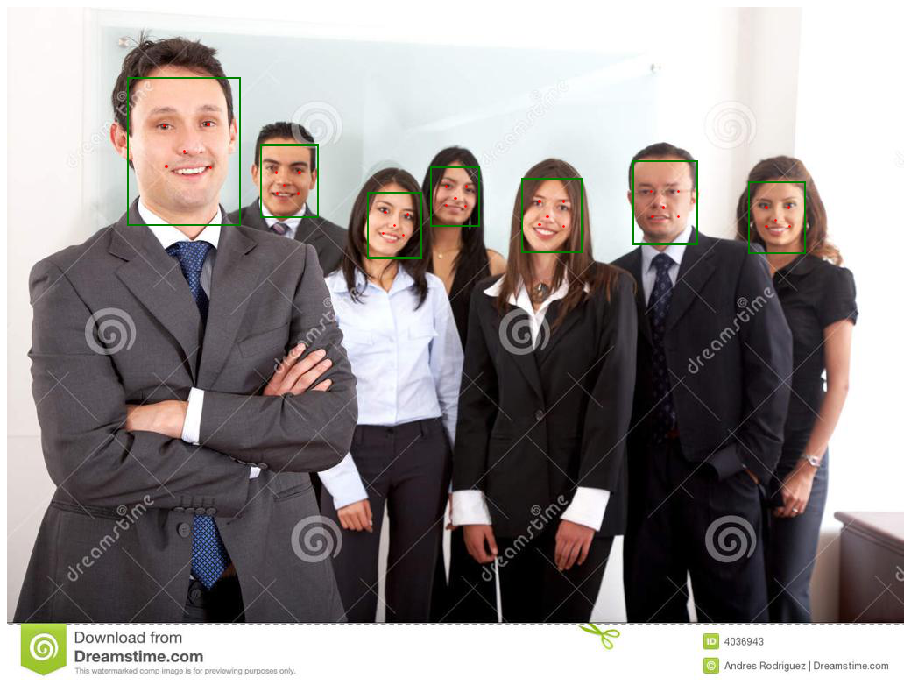

In [50]:
def my_show_landmarks(img, boxes, landmarks):
    fig, ax = plt.subplots(figsize=(20,10))
    ax = plt.subplot(1, 1, 1)
    ax.imshow(img)
    plt.tight_layout()
    print(boxes.shape)

    for i in range(boxes.shape[0]):
        x1, y1, x2, y2, _ = boxes[i]
        landmark = landmarks[i]
        x = landmark[0::2]
        y = landmark[1::2]
        ax.scatter(x, y, s=10, marker='.', c='r')
        rect = plt.Rectangle((x1, y1), x2 - x1 + 1, y2 - y1 + 1, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    ax.axis('off')

my_show_landmarks(image, bbox,landmark)

In [144]:
def detect_img(img):
    since = time.time()
    pnet_path = '/Users/shaotianyuan/PycharmProjects/face_detection/mtcnn/model_store/pnet.pkl'
    rnet_path = '/Users/shaotianyuan/PycharmProjects/face_detection/mtcnn/model_store/rnet.pkl'
    onet_path = '/Users/shaotianyuan/PycharmProjects/face_detection/mtcnn/model_store/onet.pkl'
    
    _, P_boxes_align = detect_pnet(image, pnet_path)
    _, R_boxes_align = detect_rnet(image, P_boxes_align, rnet_path)
    bbox, landmarks = detect_onet(image, R_boxes_align, onet_path)
    boxes = [P_boxes_align, R_boxes_align, bbox]
    
    fig = plt.figure(figsize=(20, 10))
    
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.tight_layout()
        ax.imshow(img)
        ax.axis('off')
        
        if boxes[i] is None:
            continue
        print(boxes[i].shape)
        
        
        for j in range(boxes[i][:30].shape[0]):
            x1, y1, x2, y2, _ = boxes[i][j]
            rect = plt.Rectangle((x1, y1), x2 - x1 + 1, y2 - y1 + 1, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            
            if i == 2:
                landmark = landmarks[j]
                x = landmark[0::2]
                y = landmark[1::2]
                ax.scatter(x, y, s=5, marker='.', c='r')
    
    time_elapesd = time.time() - since

    print(f'img_size: {img.shape[:2]} , time: {round(time_elapesd, 2)}')
            

(943, 5)
(18, 5)
(2, 5)
img_size: (683, 1024) , time: 1.1


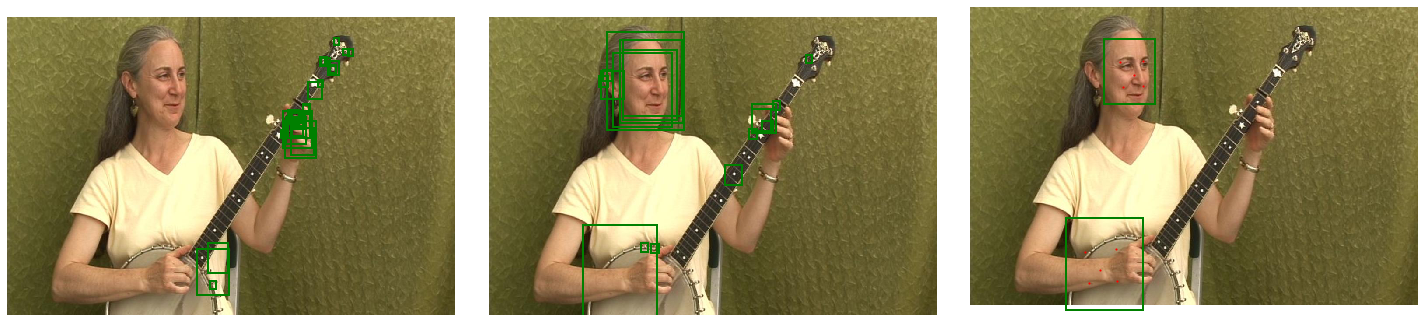

In [145]:
n = random.randint(0, len(lines))
image = image = np.array(Image.open(os.path.join(im_dir,lines[n][0])))

detect_img(image)

(-0.5, 1023.5, 682.5, -0.5)

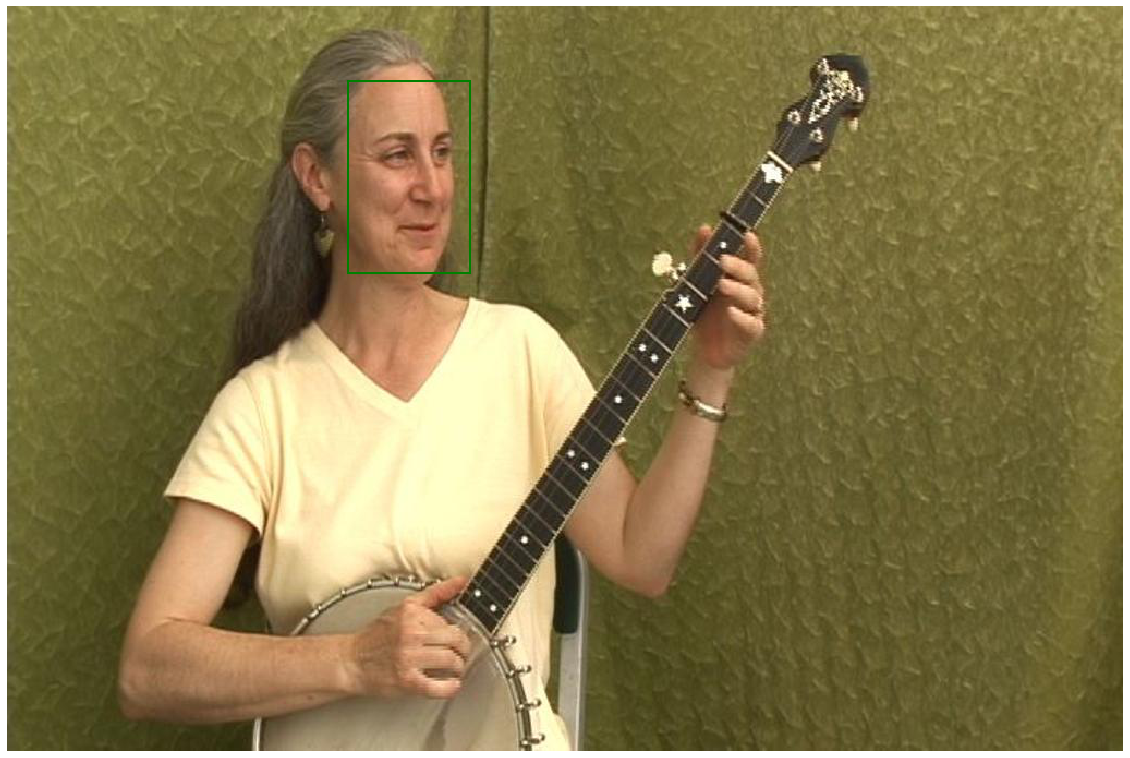

In [146]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(image)
loc = np.array(lines[n][2:]).reshape(-1, 4)
for x1, y1, x2, y2 in loc:
    rect = plt.Rectangle((x1, y1), x2, y2, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
ax.axis('off')